# nvImageCodec transcode examples

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
#os.environ["PYNVIMGCODEC_VERBOSITY"] = "5"
from nvidia import nvimgcodec

Setting resource folder and creation of nvImageCodec decoder and encoder

In [2]:
resources_dir = os.getenv("PYNVIMGCODEC_EXAMPLES_RESOURCES_DIR", "../assets/images/")

decoder = nvimgcodec.Decoder()
encoder = nvimgcodec.Encoder()

### Lossless uint8

codec: png   ; data type: uint8; encoded size=610KB; is image equal after transcoding: True
codec: bmp   ; data type: uint8; encoded size=912KB; is image equal after transcoding: True
codec: jpeg2k; data type: uint8; encoded size=507KB; is image equal after transcoding: True
codec: pnm   ; data type: uint8; encoded size=912KB; is image equal after transcoding: True
codec: tiff  ; data type: uint8; encoded size=912KB; is image equal after transcoding: True


TIFFReadDirectory: Warning, Unknown field with tag 317 (0x13d) encountered.


codec: webp  ; data type: uint8; encoded size=388KB; is image equal after transcoding: True


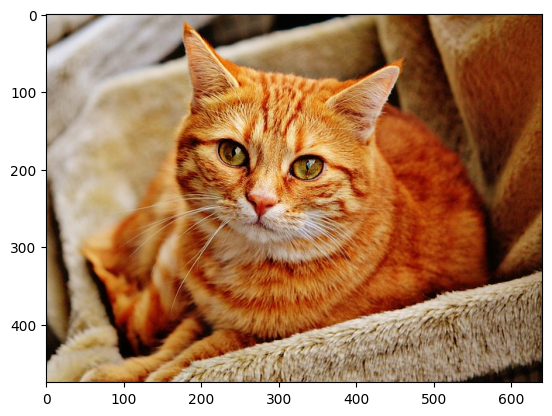

In [3]:
example_image = np.asarray(decoder.read(resources_dir + "cat-1046544_640.jp2").cpu())
plt.imshow(example_image)

for codec in ["png", "bmp", "jpeg2k", "pnm", "tiff", "webp"]:
    encode_params = nvimgcodec.EncodeParams(quality_type=nvimgcodec.QualityType.LOSSLESS)

    encoded = encoder.encode(example_image, codec, params=encode_params)
    decoded = np.asarray(decoder.decode(encoded).cpu())

    print(f"codec: {codec:6}; data type: {decoded.dtype}; encoded size={encoded.size // 1000}KB; is image equal after transcoding:", (decoded == example_image).all())

### Lossless uint16

In [4]:
example_image = np.asarray(decoder.read(resources_dir + "cat-1046544_640.jp2").cpu())
example_image = example_image.astype(np.uint16) * 255 # Convert to uint16

for codec in ["png", "jpeg2k", "pnm", "tiff"]:
    encode_params = nvimgcodec.EncodeParams(quality_type=nvimgcodec.QualityType.LOSSLESS)
    encoded = encoder.encode(example_image, codec, params=encode_params)

    # DecodeParams are required to decode into uint16 instead of uint8
    decode_params = nvimgcodec.DecodeParams(allow_any_depth=True)
    decoded = np.asarray(decoder.decode(encoded, params=decode_params).cpu())

    print(f"codec: {codec:6}; data type: {decoded.dtype}; encoded size={encoded.size // 1000:4}KB; is image equal after transcoding:", (decoded == example_image).all())

codec: png   ; data type: uint16; encoded size=1222KB; is image equal after transcoding: True
codec: jpeg2k; data type: uint16; encoded size=1395KB; is image equal after transcoding: True
codec: pnm   ; data type: uint16; encoded size=1824KB; is image equal after transcoding: True
codec: tiff  ; data type: uint16; encoded size=1825KB; is image equal after transcoding: True


TIFFReadDirectory: Warning, Unknown field with tag 317 (0x13d) encountered.


### Lossless int16

In [5]:
example_image = np.asarray(decoder.read(resources_dir + "cat-1046544_640.jp2").cpu())
example_image = (example_image.astype(np.int16) - 128) * 255 # Convert to int16

for codec in ["jpeg2k"]:
    encode_params = nvimgcodec.EncodeParams(quality_type=nvimgcodec.QualityType.LOSSLESS)
    encoded = encoder.encode(example_image, codec, params=encode_params)

    # DecodeParams are required to decode into int16 instead of uint8
    decode_params = nvimgcodec.DecodeParams(allow_any_depth=True)
    decoded = np.asarray(decoder.decode(encoded, params=decode_params).cpu())

    print(f"codec: {codec:6}; data type: {decoded.dtype}; encoded size={encoded.size// 1000}KB; is image equal after transcoding:", (decoded == example_image).all(),)

codec: jpeg2k; data type: int16; encoded size=1395KB; is image equal after transcoding: True


### Lossess uint16 with alpha channel

In [6]:
cs = nvimgcodec.CodeStream(resources_dir + "4ch16bpp.jp2")
print("Source code stream")
print(f" - color specification: {cs.color_spec}")
print(f" - sample format: {cs.sample_format}")

# Define DecodeParams to allow any depth and decode uint16 with unchanged color specification and sample format interleaved
decode_params = nvimgcodec.DecodeParams(allow_any_depth=True, color_spec = nvimgcodec.UNCHANGED)

source_img = decoder.decode(cs, params =  decode_params)
print("Decoded source image")
print (f" - color specification: {source_img.color_spec}")
print (f" - sample format: {source_img.sample_format}")
print (f" - shape: {source_img.shape}")
print (f" - dtype: {source_img.dtype}")

for codec in ["png","jpeg2k"]:
    encode_params = nvimgcodec.EncodeParams(quality_type=nvimgcodec.QualityType.LOSSLESS)
    if codec == "jpeg2k":
        encode_params.jpeg2k_params = nvimgcodec.Jpeg2kEncodeParams(bitstream_type=nvimgcodec.Jpeg2kBitstreamType.JP2)
        
    encoded = encoder.encode(source_img, codec, params = encode_params)
    print(f"Encoded {codec} code stream")
    print(f" - color specification: {encoded.color_spec}")
    print(f" - sample format: {encoded.sample_format}")
    print(f" - dtype: {encoded.dtype}")
    
    target_img = decoder.decode(encoded, params = decode_params)
    print(f"Decoded target {codec} image")
    print (f" - color specification: {target_img.color_spec}")
    print (f" - sample format: {target_img.sample_format}")
    print (f" - shape: {target_img.shape}")
    print (f" - dtype: {target_img.dtype}")
    
    are_equal= (np.asarray(target_img.cpu()) == np.asarray(source_img.cpu())).all()
    print(f"codec: {codec}; data type: {target_img.dtype}; encoded size={encoded.size// 1000}KB; is image equal after transcoding:", are_equal)

Source code stream
 - color specification: ColorSpec.SRGB
 - sample format: SampleFormat.P_RGBA
Decoded source image
 - color specification: ColorSpec.SRGB
 - sample format: SampleFormat.I_RGBA
 - shape: (497, 497, 4)
 - dtype: uint16
Encoded png code stream
 - color specification: ColorSpec.SRGB
 - sample format: SampleFormat.I_RGBA
 - dtype: uint16
Decoded target png image
 - color specification: ColorSpec.SRGB
 - sample format: SampleFormat.I_RGBA
 - shape: (497, 497, 4)
 - dtype: uint16
codec: png; data type: uint16; encoded size=230KB; is image equal after transcoding: True
Encoded jpeg2k code stream
 - color specification: ColorSpec.SRGB
 - sample format: SampleFormat.I_RGBA
 - dtype: uint16
Decoded target jpeg2k image
 - color specification: ColorSpec.SRGB
 - sample format: SampleFormat.I_RGBA
 - shape: (497, 497, 4)
 - dtype: uint16
codec: jpeg2k; data type: uint16; encoded size=301KB; is image equal after transcoding: True


### Lossy uint8
Quality values used are low, so that the difference between original and transcoded images is easy to spot.


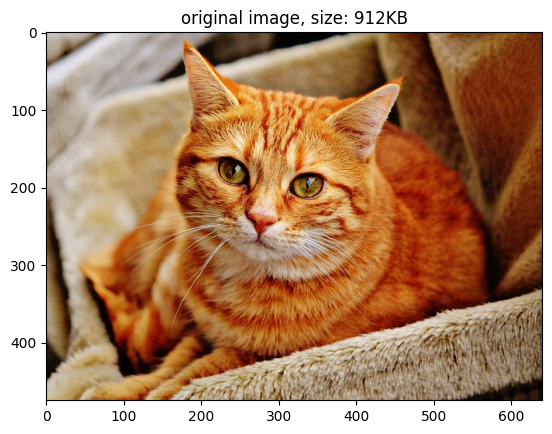

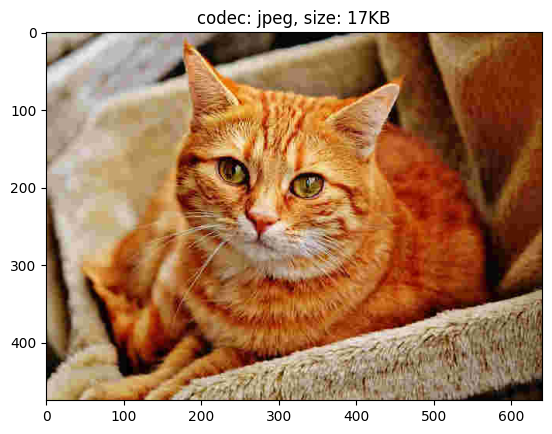

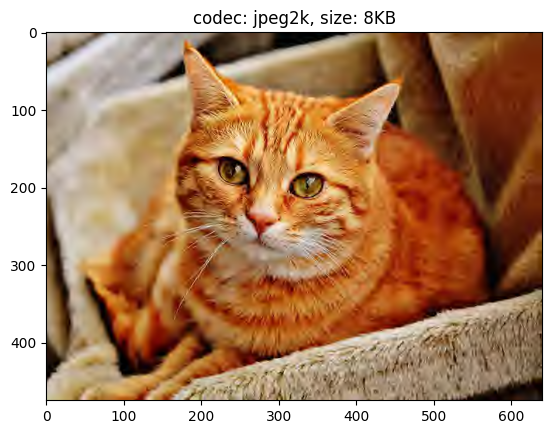

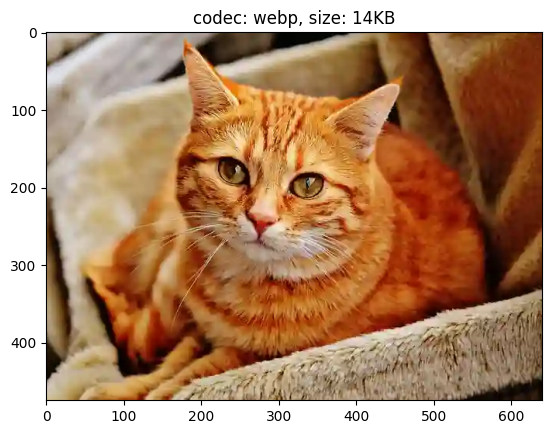

In [7]:
example_image = np.asarray(decoder.read(resources_dir + "cat-1046544_640.jp2").cpu())
plt.title(f"original image, size: {example_image.size // 1000}KB")
plt.imshow(example_image)
plt.show()

for codec in ["jpeg", "jpeg2k", "webp"]:
    encode_params = nvimgcodec.EncodeParams(quality_type=nvimgcodec.QualityType.QUALITY, quality_value=10)
    if codec == "jpeg2k":
        # jpeg2k must be encoded to YCC to be able to use quality and to do that multi-component transformation needs to be enabled
        encode_params.jpeg2k_params = nvimgcodec.Jpeg2kEncodeParams(mct_mode=1)

    encoded = encoder.encode(example_image, codec, params=encode_params)
    decoded = np.asarray(decoder.decode(encoded).cpu())
    plt.title(f"codec: {codec}, size: {encoded.size // 1000}KB")
    plt.imshow(decoded)
    plt.show()